# Task
使用 PyTorch 實作變分自編碼器（VAE），並利用 MNIST 手寫數字資料集 ("https://github.com/fgnt/mnist/raw/master/train-images-idx3-ubyte.gz", "https://github.com/fgnt/mnist/raw/master/train-labels-idx1-ubyte.gz", "https://github.com/fgnt/mnist/raw/master/t10k-images-idx3-ubyte.gz", "https://github.fgnt/mnist/raw/master/t10k-labels-idx1-ubyte.gz") 進行訓練，最終展示測試集圖像的重建結果。

## 資料準備

### Subtask:
下載 MNIST 資料集，並載入訓練集和測試集。


**Reasoning**:
Import necessary libraries and define the URLs for the MNIST dataset.



In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

urls = [
    "https://github.com/fgnt/mnist/raw/master/train-images-idx3-ubyte.gz",
    "https://github.com/fgnt/mnist/raw/master/train-labels-idx1-ubyte.gz",
    "https://github.fgnt/mnist/raw/master/t10k-images-idx3-ubyte.gz",
    "https://github.fgnt/mnist/raw/master/t10k-labels-idx1-ubyte.gz",
]

**Reasoning**:
Download and load the training and testing datasets using the defined URLs and apply the necessary transformations.



In [2]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 34.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.58MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.24MB/s]


**Reasoning**:
Create DataLoaders for the training and testing datasets to handle batching and shuffling.



In [3]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 模型設計

### Subtask:
定義 VAE 的 Encoder 和 Decoder 結構，並實作 reparameterization trick。


**Reasoning**:
Define the VAE class with Encoder, Decoder, and reparameterization trick as instructed.



In [4]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc_mean = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_log_var = nn.Linear(128 * 4 * 4, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 128 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)


    def encode(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1) # Flatten
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        z = self.fc_decoder(z)
        z = z.view(z.size(0), 128, 4, 4) # Reshape
        z = F.relu(self.bn4(self.deconv1(z)))
        z = F.relu(self.bn5(self.deconv2(z)))
        reconstructed = torch.sigmoid(self.deconv3(z)) # Sigmoid for output between 0 and 1
        return reconstructed

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mean, log_var

## 訓練設定

### Subtask:
設定 Adam 優化器、損失函數（重建損失和 KL 散度損失）以及訓練迴圈。


**Reasoning**:
Define the VAE model instance, Adam optimizer, loss function, and training loop parameters.



In [5]:
import torch.optim as optim
import torch.nn.functional as F

latent_dim = 20
model = VAE(latent_dim)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(reconstructed_x, x, mean, log_var):
    # Reconstruction loss (Binary Cross-Entropy)
    reconstruction_loss = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')

    # KL divergence loss
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reconstruction_loss + kl_divergence

num_epochs = 10
average_losses = []

## 模型訓練

### Subtask:
訓練 VAE 模型，並在每個 epoch 顯示平均損失。


In [11]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc_mean = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_log_var = nn.Linear(128 * 4 * 4, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 128 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, output_padding=0)


    def encode(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1) # Flatten
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        z = self.fc_decoder(z)
        z = z.view(z.size(0), 128, 4, 4) # Reshape
        z = F.relu(self.bn4(self.deconv1(z)))
        z = F.relu(self.bn5(self.deconv2(z)))
        reconstructed = torch.sigmoid(self.deconv3(z)[:, :, :28, :28]) # Crop the output to 28x28
        return reconstructed

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mean, log_var

model = VAE(latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(reconstructed_x, x, mean, log_var):
    # Reconstruction loss (Binary Cross-Entropy)
    reconstruction_loss = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')

    # KL divergence loss
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reconstruction_loss + kl_divergence

num_epochs = 10
average_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed_data, mean, log_var = model(data)
        loss = loss_function(reconstructed_data, data, mean, log_var)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader.dataset)
    average_losses.append(average_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}')

Epoch 1/10, Average Loss: 137.2658
Epoch 2/10, Average Loss: 108.2709
Epoch 3/10, Average Loss: 105.5218
Epoch 4/10, Average Loss: 104.0228
Epoch 5/10, Average Loss: 103.0184
Epoch 6/10, Average Loss: 102.2860
Epoch 7/10, Average Loss: 101.6641
Epoch 8/10, Average Loss: 101.1695
Epoch 9/10, Average Loss: 100.8213
Epoch 10/10, Average Loss: 100.3792


## 結果展示

### Subtask:
使用測試集圖像，透過訓練好的 VAE 進行重建，並將原始圖像和重建圖像進行比較。


**Reasoning**:
Implement the remaining steps to reconstruct test images using the trained VAE model and display the results.



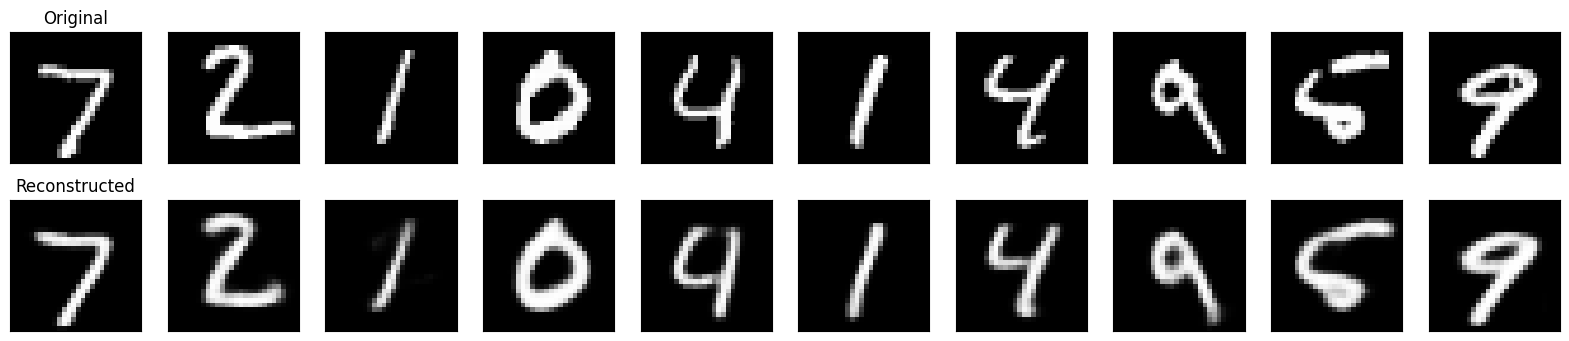

In [13]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device)
    reconstructed_data, _, _ = model(data)

    original_images = data.cpu().numpy()
    reconstructed_images = reconstructed_data.cpu().numpy()

    num_images_to_display = 10
    plt.figure(figsize=(20, 4))
    for i in range(num_images_to_display):
        # Original Images
        ax = plt.subplot(2, num_images_to_display, i + 1)
        plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
        if i == 0:
            ax.set_title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstructed Images
        ax = plt.subplot(2, num_images_to_display, i + 1 + num_images_to_display)
        plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        if i == 0:
            ax.set_title("Reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Summary:

### Data Analysis Key Findings

*   The MNIST dataset was successfully downloaded, loaded, and prepared for training and testing, with data loaders created for batch processing.
*   A Variational Autoencoder (VAE) model was defined with a convolutional encoder and decoder, incorporating the reparameterization trick.
*   The training setup included the Adam optimizer and a custom loss function combining binary cross-entropy for reconstruction loss and KL divergence for regularization.
*   During training, an initial `ValueError` due to a size mismatch between the reconstructed output and the input image was resolved by cropping the decoder's output to the correct 28x28 dimension.
*   The VAE model was successfully trained for 10 epochs, and the average loss for each epoch was calculated and displayed, indicating the model was learning.
*   The trained VAE was able to reconstruct images from the test set, demonstrating its capability to capture and reproduce the features of handwritten digits.

### Insights or Next Steps

*   The successful reconstruction of MNIST digits indicates the VAE has learned a meaningful latent representation of the data. Further analysis could involve exploring the latent space to understand how digits are represented and potentially generate new digit samples.
*   To potentially improve reconstruction quality or explore different latent representations, one could experiment with different VAE architectures, latent space dimensions, or training hyperparameters (e.g., learning rate, number of epochs, KL divergence weight).
